In [5]:
%matplotlib inline
# %%capture
# python libraties
import os, itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
from glob import glob
from PIL import Image
import time
import copy
# pytorch libraries
import torch
import torch.nn.functional as F
from torch import optim,nn
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import DataLoader,Dataset, TensorDataset
from torchvision import models, transforms, utils


# sklearn libraries
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [6]:
# data directory 
data_dir = 'data'   

In [7]:
def set_parameter_requires_grad(model, finetuning = False):
    '''
        This function freezes the parameters of the model.
        
        Parameters:
            model: model to be freezed before training
            finetuning: if finetuning is true then the model will not be freezed
        
        Returns:
            Nothing
    '''
    if not finetuning:
        print(finetuning)
        for param in model.parameters():
            param.requires_grad = False
    else: 
        print(finetuning)
        for param in model.parameters():
            param.requires_grad = True

In [ ]:
class CustomModel(nn.Module):
    def __init__(self):
        super(CustomModel, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size = 5, stride = 1, padding = 2),
            nn.Relu(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size = 5, stride = 1, padding = 2),
            nn.Relu(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )
        

In [97]:
import math

class Dense_Block(nn.Module):
	def __init__(self, in_channels):
		super(Dense_Block, self).__init__()

		self.relu = nn.ReLU(inplace = True)
		self.bn = nn.BatchNorm2d(num_features = in_channels)

		self.conv1 = nn.Conv2d(in_channels = in_channels, out_channels = 32, kernel_size = 3, stride = 1, padding = 1)
		self.conv2 = nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 3, stride = 1, padding = 1)
		self.conv3 = nn.Conv2d(in_channels = 64, out_channels = 32, kernel_size = 3, stride = 1, padding = 1)
		self.conv4 = nn.Conv2d(in_channels = 96, out_channels = 32, kernel_size = 3, stride = 1, padding = 1)
		self.conv5 = nn.Conv2d(in_channels = 128, out_channels = 32, kernel_size = 3, stride = 1, padding = 1)

    
	def forward(self, x):

		bn = self.bn(x)
		conv1 = self.relu(self.conv1(bn))

		conv2 = self.relu(self.conv2(conv1))
		c2_dense = self.relu(torch.cat([conv1, conv2], 1))

		conv3 = self.relu(self.conv3(c2_dense))
		c3_dense = self.relu(torch.cat([conv1, conv2, conv3], 1))

		conv4 = self.relu(self.conv4(c3_dense))
		c4_dense = self.relu(torch.cat([conv1, conv2, conv3, conv4], 1))

		conv5 = self.relu(self.conv5(c4_dense))
		c5_dense = self.relu(torch.cat([conv1, conv2, conv3, conv4, conv5], 1))

		return c5_dense


class Transition_Layer(nn.Module):
	def __init__(self, in_channels, out_channels):
		super(Transition_Layer, self).__init__()

		self.relu = nn.ReLU(inplace = True)
		self.bn = nn.BatchNorm2d(num_features = out_channels)
		self.conv = nn.Conv2d(in_channels = in_channels, out_channels = out_channels, kernel_size = 1, bias = False)
		self.avg_pool = nn.AvgPool2d(kernel_size = 2, stride = 2, padding = 0)

	def forward(self, x):

		bn = self.bn(self.relu(self.conv(x)))
		out = self.avg_pool(bn)

		return out


class DenseNet(nn.Module):
	def __init__(self, nr_classes):
		super(DenseNet, self).__init__()

		self.lowconv = nn.Conv2d(in_channels = 3, out_channels = 64, kernel_size = 7, padding = 3, bias = False)
		self.relu = nn.ReLU()

		# Make Dense Blocks
		self.denseblock1 = self._make_dense_block(Dense_Block, 64)
		self.denseblock2 = self._make_dense_block(Dense_Block, 128)
		self.denseblock3 = self._make_dense_block(Dense_Block, 128)

		# Make transition Layers
		self.transitionLayer1 = self._make_transition_layer(Transition_Layer, in_channels = 160, out_channels = 128)
		self.transitionLayer2 = self._make_transition_layer(Transition_Layer, in_channels = 160, out_channels = 128)
		self.transitionLayer3 = self._make_transition_layer(Transition_Layer, in_channels = 160, out_channels = 64)

		# Classifier
		self.bn = nn.BatchNorm2d(num_features = 64)
		self.pre_classifier = nn.Linear(64*4*4, 512)
		self.classifier = nn.Linear(512, nr_classes)

	def _make_dense_block(self, block, in_channels):
		layers = []
		layers.append(block(in_channels))
		return nn.Sequential(*layers)

	def _make_transition_layer(self, layer, in_channels, out_channels):
		modules = []
		modules.append(layer(in_channels, out_channels))
		return nn.Sequential(*modules)

	def forward(self, x):
		out = self.relu(self.lowconv(x))

		out = self.denseblock1(out)
		out = self.transitionLayer1(out)

		out = self.denseblock2(out)
		out = self.transitionLayer2(out)

		out = self.denseblock3(out)
		out = self.transitionLayer3(out)
    
		out = self.bn(out)
		out = out.view(-1, 64*4*4)

		out = self.pre_classifier(out)
		out = self.classifier(out)

		return out


In [98]:
model = DenseNet(7)

In [99]:
model

DenseNet(
  (lowconv): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
  (relu): ReLU()
  (denseblock1): Sequential(
    (0): Dense_Block(
      (relu): ReLU(inplace=True)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv4): Conv2d(96, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv5): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
  )
  (transitionLayer1): Sequential(
    (0): Transition_Layer(
      (relu): ReLU(inplace=True)
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv): Conv2d(160, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (avg_pool): AvgPool2

In [8]:
class FCModel(nn.Module):
    def __init__(self, num_ftrs, output_ftrs):
        
        super(FCModel, self).__init__()
        self.fc1 = nn.Linear(num_ftrs, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, output_ftrs)
#         self.drop1 = nn.Dropout(0.2)
#         self.drop2 = nn.Dropout(0.2)
        
        self.softmax = nn.Softmax(dim = 1)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
#         x = self.drop1(x)
        x = F.relu(self.fc2(x))
#         x = self.drop2(x)
        x = self.fc3(x)
        return self.softmax(x)
        

In [9]:
def initialize_models(model_name, num_classes = 7, fine_tuning = False):
    '''
        This function initialize3s the pretrained model
    '''
    
    model_fe = None
    input_size = 0
    
    if(model_name == 'resnet'):
        model_fe = models.resnet50(pretrained = True)
        set_parameter_requires_grad(model_fe, fine_tuning)
        num_ftrs = model_fe.fc.in_features
#         hidden_ftrs1 = model_fe.fc.out_features
#         hidden_ftrs2 = int(hidden_ftrs1 / 2)
        model_fe.fc = FCModel(num_ftrs, num_classes)
#         model_fe.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224
    
    elif(model_name == 'densenet'):
        model_fe = models.densenet201(pretrained = True)
        set_parameter_requires_grad(model_fe, fine_tuning)
        num_ftrs = model_fe.classifier.in_features
#         hidden_ftrs1 = model_fe.fc.out_features
#         hidden_ftrs2 = int(hidden_ftrs1 / 2)
        model_fe.classifier = FCModel(num_ftrs, num_classes)
#         model_fe.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224
    
    return model_fe, input_size
        

In [33]:
device = torch.device('cuda:0')
# Put the model on the device:
# model = model.to(device)
# device
# models.densenet121()

In [34]:
# mean = np.load('means.npz')
# stdevs = np.load('stdevs.npz')
# norm_mean = mean['arr_0']
# norm_std = stdevs['arr_0']
# print(norm_mean)
# print(norm_std)
norm_mean = [0.485, 0.456, 0.406]
norm_std = [0.229, 0.224, 0.225]

In [35]:
# optimizer = optim.Adam(model.fc.parameters(), lr = 0.0001)
# criterion = nn.CrossEntropyLoss().to(device)
# import pandas as pd
# df = pd.read_csv('data/validation.csv')
# df.shape[0]
size = {
    'train': 28428,
    'test' : 2217,
    'val' : 1092
}

In [36]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25, best_acc = 0.0):
    since = time.time()
    
    val_acc, val_loss = [],[]
    train_acc, train_loss = [],[]
    lr_rate = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
#     best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
#                 print('phase train')
                for param_group in optimizer.param_groups:
                    print('Learning Rate {}'.format(param_group['lr']))
                    lr_rate.append(param_group['lr'])
                model.train()  # Set model to training mode
            else:
#                 print('phase val')
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm(dataloader[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            del inputs
            del labels
            torch.cuda.empty_cache()
                
            if phase == 'train':
                scheduler.step(loss)

            epoch_loss = running_loss / size[phase]
            epoch_acc = running_corrects.double() / size[phase]
            
            if phase == 'train':
                val_loss.append(epoch_loss)
                val_acc.append(epoch_acc)
            else:
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                print('Best accuracy {}'.format(best_acc))
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_loss, val_acc, train_loss, train_acc, best_acc

In [102]:
# model, input_size = initialize_models('densenet', num_classes = 7)
model = DenseNet(7)
model = model.to(device)

criterion = nn.CrossEntropyLoss().to(device)

# Observe that all parameters are being optimized
optimizer = optim.Adam(model.parameters(), lr=1.0e-3)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'min',patience=3, verbose = True)
# # torch.cuda.empty_cache()
# models.densenet121()

In [103]:
model

DenseNet(
  (lowconv): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
  (relu): ReLU()
  (denseblock1): Sequential(
    (0): Dense_Block(
      (relu): ReLU(inplace=True)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv4): Conv2d(96, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv5): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
  )
  (transitionLayer1): Sequential(
    (0): Transition_Layer(
      (relu): ReLU(inplace=True)
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv): Conv2d(160, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (avg_pool): AvgPool2

In [104]:
# transfromations for train images
input_size = 224
train_transform = transforms.Compose([transforms.Resize(input_size),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomVerticalFlip(),
#                                       transforms.RandomRotation(20),
                                      transforms.ColorJitter(brightness=0.1, contrast=0.1, hue=0.1),
                                      transforms.ToTensor(), 
                                      transforms.Normalize(norm_mean, norm_std)])
# define the transformation of the test images.
test_transform = transforms.Compose([transforms.Resize(input_size), 
                                    transforms.ToTensor(),
                                    transforms.Normalize(norm_mean, norm_std)])

In [111]:
# del model
torch.cuda.empty_cache()

In [106]:
class HamDataset(Dataset):
    def __init__(self, csvpath, transform = None):
        self.df = pd.read_csv(csvpath)
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        X = Image.open(self.df['path'][index])
        y = torch.tensor(int(self.df['cell_type_idx'][index]))
        
        if self.transform:
            X = self.transform(X)
        
        return X, y

def get_data_loader(csvpath, transform = test_transform, batch_size = 32):
    if csvpath == 'train.csv':
        transform = train_transform
    csvpath = os.path.join(data_dir, csvpath)
    dataset = HamDataset(csvpath, transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    
    return dataloader

In [107]:
# train_dl = get_data_loader('train.csv')
dataloader = {'train': get_data_loader('train.csv', batch_size = 1),
           'val': get_data_loader('validation.csv', batch_size = 1),
             'test': get_data_loader('test.csv', batch_size = 1)}

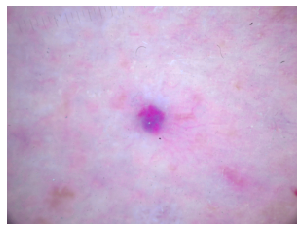

<Figure size 1440x720 with 0 Axes>

tensor([6])

<Figure size 432x288 with 0 Axes>

In [108]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.axis('off')
    plt.figure(figsize=(20,10))
#     if title is not None:
#         plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
    plt.savefig('graphs/processedimages.png')


# Get a batch of training data
# inputs contains 4 images because batch_size=4 for the dataloaders
inputs, classes = next(iter(dataloader['train']))

# Make a grid from batch
inputs = inputs[:7]
classes = classes[:7]
out = utils.make_grid(inputs)

imshow(out, title=classes)
classes

In [109]:
best_acc = 0
print(best_acc)

0


In [112]:
# optimizer = optim.SGD(model.fc.parameters(), lr=1.0e-3, momentum = 0.9)
# use Adam in next phase
# Decay LR by a factor of 0.1 every 7 epochs
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)
model, val_loss, val_acc, train_loss, train_acc, best_acc = train_model(model, criterion, optimizer, exp_lr_scheduler)

Epoch 0/24
----------
Learning Rate 0.001


RuntimeError: CUDA out of memory. Tried to allocate 18.00 MiB (GPU 0; 4.00 GiB total capacity; 2.89 GiB already allocated; 16.97 MiB free; 2.92 GiB reserved in total by PyTorch)

In [ ]:
# state = {
#     'epochs' : 35,
#     'model state dict' : model.state_dict(),
#     'optimizer state dict' : optimizer.state_dict()
# #     'val accuracy': best_val_acc
# }
# import pickle
dirr = "D:\Github\SkinCancerCapstone\models\densenet121"
# os.makedirs(dirr)
torch.save(model, os.path.join(dirr,'densenet121-new.pth'))
# with open(os.path.join(dirr, "val_loss.pickle"), 'wb') as fp:
#     pickle.dump()


In [79]:
# for x in val_loss:
#     total_val_loss.sppend(x)
# for x in val_acc:
#     total_val_acc.sppend(x)
# for x in train_loss:
#     total_train_loss.sppend(x)
# for x in train_acc:
#     total_train_acc
    

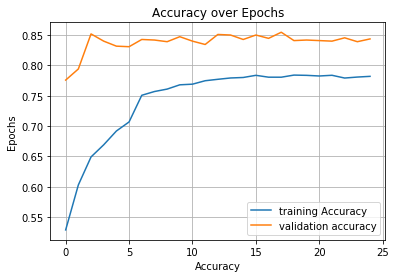

In [50]:
# fig = plt.figure(num = 2)
# fig1 = fig.add_subplot(2,1,1)
# fig2 = fig.add_subplot(2,1,2)
plt.xlabel('Accuracy')
plt.ylabel('Epochs')
plt.title('Accuracy over Epochs') 
plt.plot(val_acc, label = 'training Accuracy')
plt.plot(train_acc, label = 'validation accuracy')
plt.grid()
# fig2.plot(total_loss_val, label = 'validation acc')
# fig2.plot(total_loss_train, label = 'training accuracy')
plt.savefig('graphs/accuracy-densenetfcm.png')
plt.legend()
plt.show()

In [81]:
# val_acc

In [82]:
# train_acc

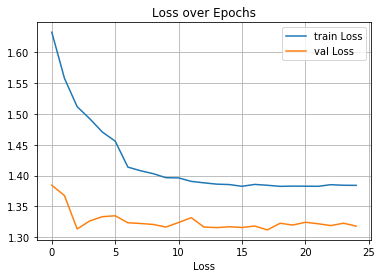

In [51]:
# fig = plt.figure(num = 2)
# fig1 = fig.add_subplot(2,1,1)
# fig2 = fig.add_subplot(2,1,2)
plt.xlabel('Loss')
plt.title('Loss over Epochs')
plt.plot(val_loss, label = 'train Loss')
plt.plot(train_loss, label = 'val Loss')
plt.grid()
# fig2.plot(total_loss_val, label = 'validation acc')
# fig2.plot(total_loss_train, label = 'training accuracy')
plt.savefig('graphs/loss-densenetfcm.png')
plt.legend()
plt.show()

In [70]:
# val_loss

In [71]:
# train_loss

In [1]:
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('graphs/conf_mat.png')
    plt.show()

NameError: name 'plt' is not defined

In [53]:
model.eval()
y_label = []
y_predict = []
with torch.no_grad():
    for images, labels in tqdm(dataloader['test']):
#         images, labels = data
        N = images.size(0)
        images = Variable(images).to(device)
        outputs = model(images)
        prediction = outputs.max(1, keepdim=True)[1]
        y_label.extend(labels.cpu().numpy())
        y_predict.extend(np.squeeze(prediction.cpu().numpy().T))

# compute the confusion matrix
confusion_mtx = confusion_matrix(y_label, y_predict)
# plot the confusion matrix
plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'nv', 'vasc','mel']
# plot_confusion_matrix(confusion_mtx, plot_labels)

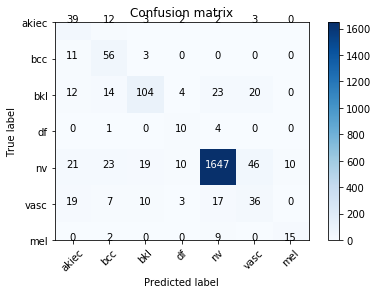

In [54]:
plot_confusion_matrix(confusion_mtx, plot_labels)

In [55]:
# Generate a classification report
report = classification_report(y_label, y_predict, target_names=plot_labels)
print(report)

              precision    recall  f1-score   support

       akiec       0.38      0.64      0.48        61
         bcc       0.49      0.80      0.61        70
         bkl       0.75      0.59      0.66       177
          df       0.34      0.67      0.45        15
          nv       0.97      0.93      0.95      1776
        vasc       0.34      0.39      0.37        92
         mel       0.60      0.58      0.59        26

    accuracy                           0.86      2217
   macro avg       0.55      0.66      0.59      2217
weighted avg       0.88      0.86      0.87      2217



In [67]:
from PIL import Image

def predict(path, modelpath = "D:\Github\SkinCancerCapstone\models\densenet121\densenet121-new.pth"):
    model = torch.load(modelpath)
#     model.to('cuda')
    model.eval()
    
    img = Image.open(path)
    img = test_transform(img).float()
    img = Variable(img, requires_grad=False)
    img = img.unsqueeze(0).cuda()
    output = model(img)
    print(output)
    prediction = output.max(1, keepdim=True)[1]
    print(prediction)
#     y_label.extend(labels.cpu().numpy())
#     y_predict.extend(np.squeeze(prediction.cpu().numpy().T))
#     print(y_predict)
# imsize = 224
# loader = transforms.Compose([transforms.Resize(input_size), 
#                                     transforms.ToTensor(),
#                                     transforms.Normalize(norm_mean, norm_std)])

# def image_loader(image_name):
#     """load image, returns cuda tensor"""
#     image = Image.open(image_name)
#     image = loader(image).float()
#     image = Variable(image, requires_grad=True)
#     image = image.unsqueeze(0)  #this is for VGG, may not be needed for ResNet
#     return image.cuda()  #assumes that you're using GPU

# image = image_loader(PATH TO IMAGE)

# your_trained_net(image)

predict("D:/Github/SkinCancerCapstone/report/img/nv.jpg")

tensor([[7.9619e-16, 1.6620e-10, 4.4542e-05, 1.4011e-08, 5.8515e-02, 1.2037e-05,
         9.4143e-01]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor([[6]], device='cuda:0')


In [ ]:
# thereare about 300 lines code excluding comments